In [1]:
import random
import torch
import numpy as np
from datasets import load_dataset

RNG_SEED = 42
random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

DATASET = "ljnlonoljpiljm/visual-genome-region-descriptions"
SAMPLE_INDEX = 0
print("Loading dataset...")
ds = load_dataset(DATASET, split="train[:50]")
sample = ds[SAMPLE_INDEX]

print("Sample keys:", sample.keys())
original_img = sample["image"]


Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

data/train-00000-of-00018.parquet:   0%|          | 0.00/908M [00:00<?, ?B/s]

data/train-00001-of-00018.parquet:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

data/train-00002-of-00018.parquet:   0%|          | 0.00/795M [00:00<?, ?B/s]

data/train-00003-of-00018.parquet:   0%|          | 0.00/795M [00:00<?, ?B/s]

data/train-00004-of-00018.parquet:   0%|          | 0.00/791M [00:00<?, ?B/s]

data/train-00005-of-00018.parquet:   0%|          | 0.00/798M [00:00<?, ?B/s]

data/train-00006-of-00018.parquet:   0%|          | 0.00/797M [00:00<?, ?B/s]

data/train-00007-of-00018.parquet:   0%|          | 0.00/794M [00:00<?, ?B/s]

data/train-00008-of-00018.parquet:   0%|          | 0.00/787M [00:00<?, ?B/s]

data/train-00009-of-00018.parquet:   0%|          | 0.00/794M [00:00<?, ?B/s]

data/train-00010-of-00018.parquet:   0%|          | 0.00/797M [00:00<?, ?B/s]

data/train-00011-of-00018.parquet:   0%|          | 0.00/792M [00:00<?, ?B/s]

data/train-00012-of-00018.parquet:   0%|          | 0.00/797M [00:00<?, ?B/s]

data/train-00013-of-00018.parquet:   0%|          | 0.00/790M [00:00<?, ?B/s]

data/train-00014-of-00018.parquet:   0%|          | 0.00/796M [00:00<?, ?B/s]

data/train-00015-of-00018.parquet:   0%|          | 0.00/792M [00:00<?, ?B/s]

data/train-00016-of-00018.parquet:   0%|          | 0.00/790M [00:00<?, ?B/s]

data/train-00017-of-00018.parquet:   0%|          | 0.00/793M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/108077 [00:00<?, ? examples/s]

Sample keys: dict_keys(['uuid', 'url', 'image', 'caption', 'detailed_caption', 'tags', 'dataset', 'points', 'objects', 'image_width', 'image_height', 'aesthetic_score', 'sensitivity_score'])


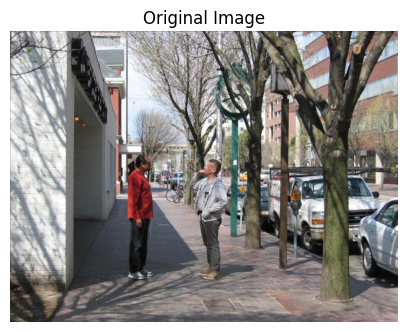

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    if title: plt.title(title)
    plt.axis("off")
    plt.show()

show(original_img, "Original Image")

In [3]:
objects = []
obj_data = sample["objects"]

for i in range(len(obj_data["label"])):
    objects.append({
        "label": obj_data["label"][i],
        "x_min": obj_data["x_min"][i],
        "y_min": obj_data["y_min"][i],
        "x_max": obj_data["x_max"][i],
        "y_max": obj_data["y_max"][i],
    })

print(f"Found {len(objects)} object regions")

Found 262 object regions


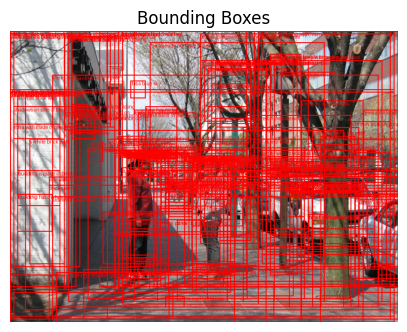

In [4]:
from PIL import ImageDraw

def draw_boxes(img, objects):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    W, H = img.size

    for obj in objects:
        box = [
            obj["x_min"] * W,
            obj["y_min"] * H,
            obj["x_max"] * W,
            obj["y_max"] * H,
        ]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1]), obj["label"], fill="red")

    return img

show(draw_boxes(original_img, objects), "Bounding Boxes")


/tmp/ipython-input-3928080998.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(mask, "L")


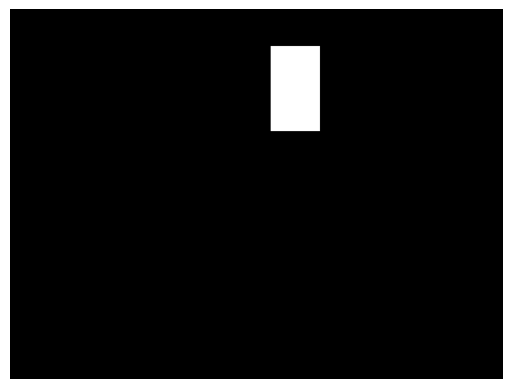

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def make_mask(img, box):
    W, H = img.size
    mask = np.zeros((H, W), dtype=np.uint8)
    x1, y1 = int(box["x_min"] * W), int(box["y_min"] * H)
    x2, y2 = int(box["x_max"] * W), int(box["y_max"] * H)
    mask[y1:y2, x1:x2] = 255
    return Image.fromarray(mask, "L")

mask_img = make_mask(original_img, objects[0])

plt.imshow(mask_img, cmap='gray')
plt.axis("off")
plt.show()


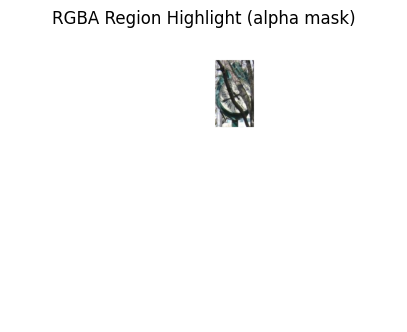

In [6]:
def apply_mask(img, mask_img):
    rgb = img.convert("RGB")
    rgba = Image.merge("RGBA", (*rgb.split(), mask_img))
    return rgba

rgba_preview = apply_mask(original_img, mask_img)
show(rgba_preview, "RGBA Region Highlight (alpha mask)")


In [7]:
from transformers import CLIPModel, CLIPProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(DEVICE)
model.eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [8]:
old_conv = model.vision_model.embeddings.patch_embedding
old_w = old_conv.weight.data.clone()
out_ch, in_ch, kH, kW = old_w.shape

new_conv = torch.nn.Conv2d(4, out_ch, (kH, kW), stride=old_conv.stride, padding=old_conv.padding)
new_w = torch.zeros((out_ch, 4, kH, kW))
new_w[:, :3] = old_w
new_conv.weight = torch.nn.Parameter(new_w)
model.vision_model.embeddings.patch_embedding = new_conv


In [9]:
for p in model.parameters(): p.requires_grad = False
for p in model.vision_model.embeddings.patch_embedding.parameters(): p.requires_grad = True


In [10]:
import torchvision.transforms as T

to_tensor = T.ToTensor()
resize224 = T.Resize((224,224))

def to_rgba_tensor(pil_img, mask_img):
    rgb = pil_img.convert("RGB")
    rgba = Image.merge("RGBA", (*rgb.split(), mask_img))
    t = to_tensor(rgba)
    t = resize224(t)
    return t

tensors = []
texts = []

for obj in objects[:8]:
    m = make_mask(original_img, obj)
    t = to_rgba_tensor(original_img, m)
    tensors.append(t)
    texts.append(obj["label"])


/tmp/ipython-input-3928080998.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(mask, "L")


In [11]:
text_tokens = processor(text=texts, return_tensors="pt", padding=True).to(DEVICE)
img_batch = torch.stack(tensors).to(DEVICE)


In [12]:
import torch.nn.functional as F

def clip_loss(i, t, temp=0.07):
    i = F.normalize(i, dim=-1)
    t = F.normalize(t, dim=-1)
    logits = i @ t.t()
    labels = torch.arange(len(logits), device=DEVICE)
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

opt = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [ ]:
enameprint("Training...")
model.train()
for step in range(100):
    opt.zero_grad()
    img_feat = model.get_image_features(pixel_values=img_batch)
    txt_feat = model.get_text_features(**text_tokens)
    loss = clip_loss(img_feat, txt_feat)
    loss.backward()
    opt.step()

    if step % 20 == 0:
        print(f"Step {step} Loss: {loss.item():.4f}")


Training...
Step 0 Loss: 2.0796
Step 20 Loss: 1.9483
Step 40 Loss: 1.8976
Step 60 Loss: 1.8630
Step 80 Loss: 1.8424


In [14]:
model.eval()
img_feat = model.get_image_features(pixel_values=img_batch)
txt_feat = model.get_text_features(**text_tokens)

img_feat = F.normalize(img_feat, dim=-1)
txt_feat = F.normalize(txt_feat, dim=-1)

sims = (img_feat @ txt_feat.t()).diag().detach().cpu().numpy()
print("Per-label similarity:", np.round(sims,2))


Per-label similarity: [0.47 0.41 0.37 0.39 0.44 0.41 0.5  0.51]
